# Setup

In [1]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from experiments.irl.fair_irl import *
from imblearn.under_sampling import RandomUnderSampler
from research.irl.fair_irl import *
from research.ml.svm import SVM
from research.utils import *
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold


logging.basicConfig(level=logging.INFO)

cp = sns.color_palette()

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_colwidth', None)

# Read in Adult dataset

In [2]:
df, X, y = generate_adult_dataset(
    filepath='./../../data/adult/adult.csv',
    n=25_000,
)
rus = RandomUnderSampler(sampling_strategy=1)
X, y = rus.fit_resample(X, y)
df = X
df['y'] = y

display(df.sample(5))
temp = (
    df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    ['y'].sort_values(['mean', 'count'], ascending=False)
    .rename(columns={'mean': 'mean_y'})
)
temp

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3570  0.146218
	1  21430  0.250910



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,is_income_over_50k,is_race_white,z,y
2106,41,Local-gov,103759,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,3942,0,40,United-States,<=50K,False,True,1,0
2876,43,State-gov,218542,HS-grad,9,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K,False,False,0,0
6934,36,Private,186035,11th,7,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,40,United-States,>50K,True,True,1,1
3797,37,Self-emp-not-inc,30973,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K,False,True,1,0
4748,55,Self-emp-inc,197749,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,1573,44,United-States,<=50K,False,True,1,0


,,count,mean_y
z,gender,,
1,Male,7725,0.594563
0,Male,880,0.471591
1,Female,2634,0.297646
0,Female,559,0.191413


# Split data for expert demonstrations and learned policy iterations.

In [3]:
##
# Split data into two: (X_demo, y_demo), (X_irl_valid, y_irl_valid). The
# former is used for generating the expert's demonstrations. The latter is
# used in the IRL loop for learning the optimal policies for a given reward
# function.
##
X_demo, X_irl_valid, y_demo, y_irl_valid = train_test_split(
    X, y, test_size=.33)

del X, y  # Make sure I don't acidentally use these variables later on

# Generate Expert Demonstrations

In [4]:
##
# These are the feature types that will be used in the classifier that will
# produce the expert feature demonstrations.
##
expert_demo_feature_types = {
    'boolean': [
        'z',
        'gender',
    ],
    'categoric': [
        'workclass',
        'education',
#         'marital-status',
        # 'occupation',
        # 'relationship',
        # 'native-country',
    ],
    'continuous': [
#         'age',
        # 'educational-num',
        # 'capital-gain',
        # 'capital-loss',
        # 'hours-per-week',
    ],
    'meta': [
        'fnlwgt'
    ],
}

### Train classsifier on target variable 

In [5]:
clf_inst = RandomForestClassifier()
m = 1
muE, demosE = generate_expert_demonstrations(
    X_demo, y_demo, expert_demo_feature_types, clf_inst, n_feat_exp=3, m=m,
)
logging.info(muE)

INFO:root:
INFO:root:Generating expert demonstrations...
INFO:root:	Staring iteration 1/1
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:		Generating demo...
INFO:root:
	     yhat          
	    count      mean
	z y                
	0 0   208  0.269231
	  1   117  0.658120
	1 0  1086  0.313076
	  1  1198  0.689482

INFO:root:		Computing feature expectations...
INFO:root:		muE[0]: [0.6903028  0.60406286 0.96863719]
INFO:root:[[0.6903028  0.60406286 0.96863719]]


0.6581196581196581 0.6894824707846411


### Manually construct classifier to only care about fairness

In [66]:
lambda_female = lambda row: int(row['gender'] == 'Female')

clf_inst = ManualClassifier(lambda_female)

m = 1
muE, demosE = generate_expert_demonstrations(
    X_demo, y_demo, expert_demo_feature_types, clf_inst, n_feat_exp=3, m=m,
)
logging.info(muE)

INFO:root:
INFO:root:Generating expert demonstrations...
INFO:root:	Staring iteration 1/1
INFO:root:		Checking if classifier already fitted...
INFO:root:		Classifier already fitted. Skipping fit.
INFO:root:		Generating demo...
INFO:root:
	     yhat          
	    count      mean
	z y                
	0 0   215  0.493023
	  1   121  0.256198
	1 0  1108  0.347473
	  1  1211  0.150289

INFO:root:		Computing feature expectations...
INFO:root:		muE[0]: [0.39359699 0.83804143 0.89409067]
INFO:root:[[0.39359699 0.83804143 0.89409067]]


0.256198347107438 0.15028901734104047


# IRL Loop

In [12]:
##
# Run IRL loop.
# Create a clf dataset where inputs are feature expectations and outputs are
# whether the policy is expert or learned through IRL iterations. Then train
# an SVM classifier on this dataset. Then extract the weights of the svm and
# use them as the weights for the "reward" function. Then use this reward
# function to learn a policy (classifier). Then compute the feature
# expectations from this classifer on the irl hold-out set. Then compute the
# error between the feature expectations of this learned clf and the
# demonstration feature exp. If this error is less than epsilon, stop. The
# reward function is the final set of weights.
##


# These are the feature types that will be used in the classifier that will
# predict `y` given `X` when learning the optimal policy for a given reward
# function.
irl_loop_feature_types = {
    'boolean': [
        'z',
        'gender',
    ],
    'categoric': [
        'workclass',
        'education',
#         'marital-status',
#         'occupation',
        # 'relationship',
        # 'native-country',
    ],
    'continuous': [
#         'age',
        # 'educational-num',
        # 'capital-gain',
        # 'capital-loss',
        # 'hours-per-week',
    ],
    'meta': [
        'fnlwgt'
    ],
}
x_cols = (
    irl_loop_feature_types['boolean']
    + irl_loop_feature_types['categoric']
    + irl_loop_feature_types['continuous']
)
x_cols.remove('z')

# Generate initial policy(s) and add them to `mu`
N_INIT_POLICIES = 1
CAN_OBSERVE_Y = False
NO_NEG_WEIGHTS = False
SAMPLE_LEARNED_POLICIES = False
RANDOM_WEIGHT_RATE = 0
SKIP_ERROR_TERMS = True
METHOD = 'highs'
epsilon = .01
max_iter = 3


dummy_clf = DummyClassifier(strategy="uniform")


mu = generate_initial_policies(
    X_demo, y_demo, irl_loop_feature_types, dummy_clf,
    n_policies=N_INIT_POLICIES,
)

X_irl_exp = pd.DataFrame(muE, columns=['acc', 'disp_imp', 'eq_opp'])
y_irl_exp = pd.Series(np.ones(m), dtype=int)
X_irl_learn = pd.DataFrame(mu, columns=['acc', 'disp_imp', 'eq_opp'])
y_irl_learn = pd.Series(np.zeros(len(mu)), dtype=int)

t = []  # Errors for each iteration
mu_delta_l2norm_hist = []
weights = []
i = 0
demo_history = []
mu_history = []
is_random_weight = []

logging.info('')
logging.info('Starting IRL Loop ...')

while True:
    logging.info(f"\tIRL Loop iteration {i+1}/{max_iter} ...")
    
    # Train SVM classifier that distinguishes which demonstrations are expert
    # and which were generated from this loop.
    logging.info('\tFitting SVM classifier...')
    if SAMPLE_LEARNED_POLICIES and i > 2:
        # TRY SAMPLING FROM LEARNE DPOLICIES TO AVOID LOCAL OPTIMUM ISSUE
#         n_samples_to_use = np.random.randint(low=2, high=len(X_irl_learn)-1)
        n_samples_to_use = 2
        sampled_idx = X_irl_learn.sample(n_samples_to_use).index
        sampled_X_irl_learn = X_irl_learn.loc[sampled_idx].copy()
        sampled_y_irl_learn = y_irl_learn.loc[sampled_idx].copy()
        X_irl = pd.concat([X_irl_exp, sampled_X_irl_learn], axis=0).reset_index(drop=True)
        y_irl = pd.concat([y_irl_exp, sampled_y_irl_learn], axis=0).reset_index(drop=True)
        svm = SVM().fit(X_irl, y_irl)
    else:
        X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
        y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
        svm = SVM().fit(X_irl, y_irl)
        
    if np.random.rand() < RANDOM_WEIGHT_RATE:
        wi = np.random.rand(3)
        print(f"w[{i+N_INIT_POLICIES+1}]={wi.round(2)} were randomly generated")
        is_random_weight.append(1)
    else:
        # Extract the weights from the SVM classifier. These weights become the
        # reward weights.
        wi = svm.weights()
        is_random_weight.append(0)
    
    # Trying something out
    if NO_NEG_WEIGHTS:
        for _i, w in enumerate(wi):
            if w < 0:
                wi[_i] = 0
            
    weights.append(wi)
    
    # Learn a policy (clf_pol) from the reward (SVM) weights.
    valid_df = pd.DataFrame(X_demo)
    valid_df['y'] = y_demo
    rf = RandomForestClassifier()
    # Fit a classifier that predicts `y` from `X`.
    logging.info('\tFitting `y|x` predictor for clf policy...')
    # Learn a policy that maximizes the reward function.
    logging.info('\tComputing the optimal policy given reward weights and `y|x` classifier...')
    clf_pol = compute_optimal_policy(
        clf_df=valid_df,
        feature_types=irl_loop_feature_types,
        clf_inst=rf,
        x_cols=x_cols,
        acc_weight=wi[0],
        disp_imp_weight=wi[1],
        eq_opp_weight=wi[2],
        skip_error_terms=SKIP_ERROR_TERMS,
        method=METHOD,
    )
    
    # Compute feature expectations of the learned policy
    logging.info('\tGenerating learned demostration...')
    demo = generate_demo(clf_pol, X_irl_valid, y_irl_valid, can_observe_y=CAN_OBSERVE_Y)
    demo_history.append(demo)
    muj = compute_demo_feature_exp(demo)
    mu_history.append(muj)
    logging.info(f"\t\t muL[i] = {np.round(muj, 3)}")
    
    # Append policy's feature expectations to irl clf dataset
    X_irl_learn_i = pd.DataFrame(np.array([muj]), columns=['acc', 'disp_imp', 'eq_opp'])
    y_irl_learn_i = pd.Series(np.zeros(1), dtype=int)
    X_irl_learn = pd.concat([X_irl_learn, X_irl_learn_i], axis=0)
    y_irl_learn = pd.concat([y_irl_learn, y_irl_learn_i], axis=0)
    
    # Compute error of the learned policy: t[i] = wT(muE-mu[j])
    ti, mu_delta, mu_delta_l2norm= irl_error(wi, muE, muj)
    t.append(ti)
    mu_delta_l2norm_hist.append(mu_delta_l2norm)
    logging.info(f"\t\t mu_delta[i] \t= {np.round(mu_delta, 3)}")
    logging.info(f"\t\t t[i] \t\t= {t[i]:.5f}")
    logging.info(f"\t\t weights[{i}] \t= {np.round(weights[i], 3)}")
    
    # Show a summary of the learned policy
#     logging.info(
#         df_to_log(
#             demo.groupby(['z']+x_cols+['y', 'yhat'])[['age']].agg(['count']),
#             title='\tLearned Policy:',
#             tab_level=3,
#         )
#     )
    
    if ti < epsilon or i >= max_iter - 1:
        break
        
    i += 1
    

print('\n'+ 100*'-' + '\n')

# Compare the best learned policy with the expert demonstrations
for demo in demosE:
    print(f"Expert demo yhat:\t {demo['yhat'].mean()}")
#     display(demo.groupby(['z']+x_cols+['y'])[['yhat']].agg(['count', 'mean']))
    
print('\n'+ 100*'-' + '\n')

best_iter = np.argmin(t)
print('Best iteration: ' + str(best_iter))
best_demo = demo_history[best_iter]
print(f"Best Learned Policy yhat: {best_demo['yhat'].mean():.3f}")
# display(
#     best_demo.groupby(['z']+x_cols+['y'])[['yhat']].agg(['count', 'mean'])
# )
best_weight = weights[best_iter]
print(f"best weight:\t {np.round(best_weight, 3)}")

print('\n'+ 100*'-' + '\n')
X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
df_irl = X_irl.copy()
df_irl['is_expert'] = y_irl.copy()
df_irl['accuracy_weight'] = np.zeros(1+N_INIT_POLICIES).tolist() + [w[0] for w in weights]
df_irl['disp_imp_weight'] = np.zeros(1+N_INIT_POLICIES).tolist() + [w[1] for w in weights]
df_irl['eq_opp_weight'] = np.zeros(1+N_INIT_POLICIES).tolist() + [w[2] for w in weights]
df_irl['t'] = list(np.inf*(np.ones(1+N_INIT_POLICIES))) + t
df_irl['mu_delta_l2norm'] = np.zeros(1+N_INIT_POLICIES).tolist() + mu_delta_l2norm_hist
df_irl['is_random_weight'] = np.zeros(1+N_INIT_POLICIES).tolist() + is_random_weight
print('Historical feature expectations')
display(df_irl)

INFO:root:
INFO:root:Generating initial policy 1/1
INFO:root:	Fitting classifier...
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	Generating demo...
INFO:root:	Computing feature expectations...
INFO:root:	mu: [array([0.49980836, 0.62821004, 0.98555978])]
INFO:root:
INFO:root:Starting IRL Loop ...
INFO:root:	IRL Loop iteration 1/3 ...
INFO:root:	Fitting SVM classifier...
INFO:root:	Fitting `y|x` predictor for clf policy...
INFO:root:	Computing the optimal policy given reward weights and `y|x` classifier...


0.48148148148148145 0.49592169657422513


INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	Generating learned demostration...
INFO:root:	State Lookup Error: ('Female', 'Self-emp-inc', 'Masters', 0, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Self-emp-not-inc', '10th', 0, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Male', '?', 'Masters', 0, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Male', 'Self-emp-inc', '5th-6th', 1, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', '?', '5th-6th', 1, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Federal-gov', 'Assoc-acdm', 0, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Federal-gov', 'Doctorate', 1, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Self-emp-inc', 'Doctorate', 1, 1)
INFO:root:	Using default action: 0
INFO:ro

0.6375 0.6859738784781374


INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	Generating learned demostration...
INFO:root:	State Lookup Error: ('Female', 'Self-emp-inc', 'Masters', 0, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Self-emp-not-inc', '10th', 0, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Male', '?', 'Masters', 0, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Male', 'Self-emp-inc', '5th-6th', 1, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', '?', '5th-6th', 1, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Federal-gov', 'Assoc-acdm', 0, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Federal-gov', 'Doctorate', 1, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Self-emp-inc', 'Doctorate', 1, 1)
INFO:root:	Using default action: 0
INFO:ro

0.6375 0.05678591709256105


INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	Generating learned demostration...
INFO:root:	State Lookup Error: ('Female', 'Self-emp-inc', 'Masters', 0, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Self-emp-not-inc', '10th', 0, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Male', '?', 'Masters', 0, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Male', 'Self-emp-inc', '5th-6th', 1, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', '?', '5th-6th', 1, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Federal-gov', 'Assoc-acdm', 0, 0)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Federal-gov', 'Doctorate', 1, 1)
INFO:root:	Using default action: 0
INFO:root:	State Lookup Error: ('Female', 'Self-emp-inc', 'Doctorate', 1, 1)
INFO:root:	Using default action: 0
INFO:ro

0.6375 0.06132879045996593

----------------------------------------------------------------------------------------------------

Expert demo yhat:	 0.4978919126101955

----------------------------------------------------------------------------------------------------

Best iteration: 0
Best Learned Policy yhat: 0.485
best weight:	 [ 0.823 -0.104 -0.073]

----------------------------------------------------------------------------------------------------

Historical feature expectations


,acc,disp_imp,eq_opp,is_expert,accuracy_weight,disp_imp_weight,eq_opp_weight,t,mu_delta_l2norm,is_random_weight
0,0.690303,0.604063,0.968637,1,0.000000,0.000000,0.000000,inf,0.000000,0.0
1,0.499808,0.628210,0.985560,0,0.000000,0.000000,0.000000,inf,0.000000,0.0
2,0.694658,0.600924,0.951526,0,0.822642,-0.104279,-0.073079,0.014929,0.017933,0.0
3,0.529019,0.995634,0.419286,0,0.142936,0.100795,0.756269,0.538419,0.693634,0.0
4,0.526708,0.997946,0.423829,0,0.147084,0.099834,0.753083,0.535376,0.691898,0.0


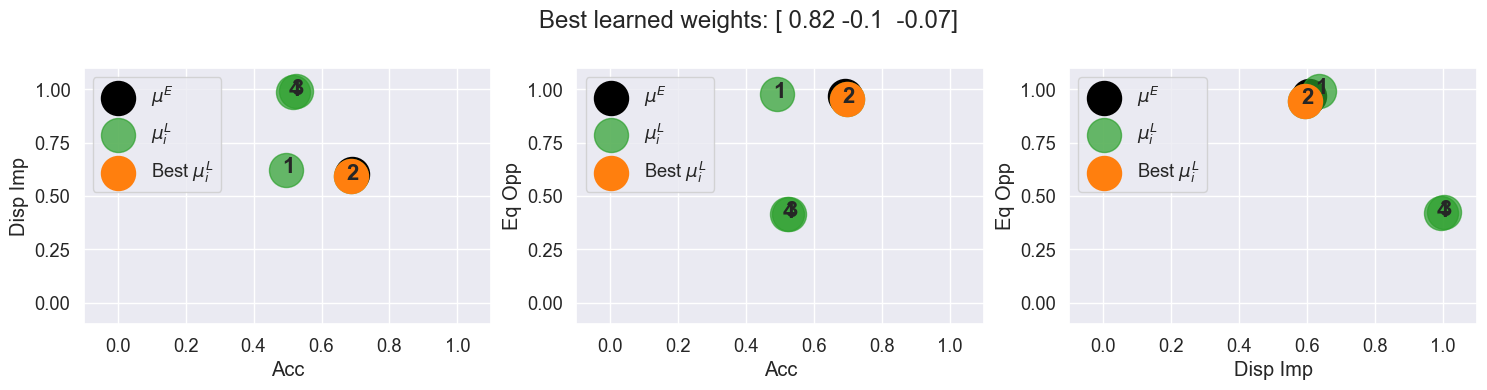

In [13]:
ANNOTATE = True
NOISE_FACTOR = .02

import itertools

sns.set_theme(style='darkgrid', font_scale=1.2)

feat_exp_space = ['acc', 'disp_imp', 'eq_opp']
feat_exp_combs = list(itertools.combinations(feat_exp_space, 2))

exp = df_irl.query('is_expert == True').reset_index(drop=True)
lrn = df_irl.query('is_expert == False and is_random_weight == 0').reset_index(drop=True)
best_t_idx = lrn.query('t > 0')['t'].argmin()

fig, axes = plt.subplots(1, len(feat_exp_combs), figsize=(5*len(feat_exp_combs), 4))
for i, (feat_exp_x, feat_exp_y) in enumerate(feat_exp_combs):
    # Plot expert
    axes[i].scatter(exp[feat_exp_x], exp[feat_exp_y], label='$\mu^E$', s=600, alpha=1, c='black')
    # Inject noise so we can see the expert when it's overlapping
    noise = NOISE_FACTOR*(np.random.rand(len(lrn))-.6)
    # Plot the learned policies
    axes[i].scatter(lrn[feat_exp_x]+noise, lrn[feat_exp_y]+noise, label='$\mu^L_i$', s=600, alpha=.7, c=cp[2])
    axes[i].set_ylim([-.1, 1.1])
    axes[i].set_xlim([-.1, 1.1])
    axes[i].set_xlabel(feat_exp_x.replace('_', ' ').title())
    axes[i].set_ylabel(feat_exp_y.replace('_', ' ').title())
    if ANNOTATE:
        # Label each learned policy with its ordered index
        for idx, row in lrn.iterrows():
            axes[i].annotate(1+idx, (-.012+(row[feat_exp_x]+noise[idx]), -.015+(row[feat_exp_y]+noise[idx])), fontsize=16, fontweight=700)
    # Color the best policy
    axes[i].scatter([lrn.loc[best_t_idx][feat_exp_x]+noise[best_t_idx]], [lrn.loc[best_t_idx][feat_exp_y]+noise[best_t_idx]], label='Best $\mu^L_i$', s=600, alpha=1, c=cp[1])
    axes[i].legend(ncol=1, labelspacing=.7, loc='upper left')

plt.suptitle(f"Best learned weights: {best_weight.round(2)}")
plt.tight_layout()

# Use learned rewards on Adult to predict on Compas dataset

In [310]:
# _df = pd.read_csv('./../../data/compas-scores-raw.csv')
# _df = pd.read_csv('./../../data/compas/propublica_data_for_fairml.csv')
# _df = pd.read_csv('./../../data/compas/cox-violent-parsed_filt.csv')
# _df = pd.read_csv('./../../data/compas/cox-violent-parsed.csv')
compas = pd.read_csv('./../../data/compas/cox-violent-parsed.csv')

In [311]:
df, X, y = generate_compas_dataset(
    filepath='./../../data/compas/cox-violent-parsed.csv',
    n=10_000,
)

display(
    df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    ['y'].sort_values(['mean', 'count'], ascending=False)
    .rename(columns={'mean': 'mean_y'})
)
rus = RandomUnderSampler(sampling_strategy=1)
X, y = rus.fit_resample(X, y)
df = X
df['y'] = y

display(
    df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    ['y'].sort_values(['mean', 'count'], ascending=False)
    .rename(columns={'mean': 'mean_y'})
)

INFO:root:Dataset count of each z, y group
INFO:root:
	      y          
	  count      mean
	z                
	0  6400  0.503906
	1  3164  0.421302



count    mean_y
z gender                 
0 Male     5424  0.530420
1 Male     2409  0.432130
  Female    755  0.386755
0 Female    976  0.356557

count    mean_y
z gender                 
0 Male     5205  0.552738
1 Male     2280  0.456579
  Female    713  0.409537
0 Female    918  0.379085

In [340]:
##
# These are the feature types that will be used in the classifier that is
# learned in the target domain and optimizes the weights learned from the
# source domain.
##
target_feature_types = {
    'boolean': [
        'z',
        'gender',
    ],
    'categoric': [
        'score_text',
    ],
    'continuous': [
#         'priors_count',
    ],
    'meta': [
    ],
}
x_cols = (
    target_feature_types['boolean']
    + target_feature_types['categoric']
    + target_feature_types['continuous']
)
x_cols.remove('z')

In [342]:
logging.info(f"Adult dataset learned weights: {np.round(best_weight, 3)}")

logging.info('\n\n'+ 100*'-' + '\n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
train_df = pd.DataFrame(X_train)
train_df['y'] = y_train
# Fit a classifier that predicts `y` from `X`.
rf = RandomForestClassifier()
logging.info('\tFitting `y|x` predictor for clf policy...')
# Learn a policy that maximizes the reward function.
logging.info('\tComputing the optimal policy given reward weights and `y|x` classifier...')
clf_pol = compute_optimal_policy(
    clf_df=train_df,
    feature_types=target_feature_types,
    clf_inst=rf,
    x_cols=x_cols,
    acc_weight=best_weight[0],
    disp_imp_weight=best_weight[1],
)

# Compute feature expectations of the learned policy
logging.info('\tGenerating learned demonstration...')
demo = generate_demo(clf_pol, X_test, y_test)
muj = compute_demo_feature_exp(demo)
logging.info(f"Accuracy of learned policy: {muj[0]:.2f}")
logging.info(f"Disp Imp of learned policy: {muj[1]:.2f}")

    
logging.info('\n\n'+ 100*'-' + '\n')

INFO:root:Adult dataset learned weights: [0.952 0.048]
INFO:root:

----------------------------------------------------------------------------------------------------

INFO:root:	Fitting `y|x` predictor for clf policy...
INFO:root:	Computing the optimal policy given reward weights and `y|x` classifier...
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	Generating learned demonstration...
INFO:root:	State Lookup Error: ('Male', nan, 1, 1)
INFO:root:	Using default action: 0
INFO:root:Accuracy of learned policy: 0.62
INFO:root:Disp Imp of learned policy: 0.76
INFO:root:

----------------------------------------------------------------------------------------------------



In [343]:
ORIGINAL_WEIGHTS = [1, 0]
logging.info('\tGenerating demonstration of the exact policy used on the original adult dataset')

# clf_inst = ManualClassifier(lambda_female)
# demo = generate_demo(clf_inst, X_test, y_test)
# muj = compute_demo_feature_exp(demo)
# logging.info(f"Accuracy of explicit policy: {muj[0]:.2f}")
# logging.info(f"Disp Imp of explicit policy: {muj[1]:.2f}")

# Learn a policy that maximizes the reward function.
logging.info('\tComputing the optimal policy given reward weights and `y|x` classifier...')
clf_inst = RandomForestClassifier()
clf_pol = compute_optimal_policy(
    clf_df=train_df,
    feature_types=target_feature_types,
    clf_inst=clf_inst,
    x_cols=x_cols,
    acc_weight=ORIGINAL_WEIGHTS[0],
    disp_imp_weight=ORIGINAL_WEIGHTS[1],
)
demo = generate_demo(clf_pol, X_test, y_test)
muj = compute_demo_feature_exp(demo)
logging.info(f"Accuracy of explicit policy: {muj[0]:.2f}")
logging.info(f"Disp Imp of explicit policy: {muj[1]:.2f}")

INFO:root:	Generating demonstration of the exact policy used on the original adult dataset
INFO:root:	Computing the optimal policy given reward weights and `y|x` classifier...
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	State Lookup Error: ('Male', nan, 1, 1)
INFO:root:	Using default action: 0
INFO:root:Accuracy of explicit policy: 0.62
INFO:root:Disp Imp of explicit policy: 0.76


# Other Notes

### Notes and Assumptions

* Meaning of `fnlwgt` column: it is the (estimated) number of people each row in the data represents. I'm removing it for now. Although we may want to consider resampling each row based on its `fnlwgt` value. See what other papers do with this column.
* There are 5 possible values for `race`. I'm going to make it binary with `White` vs `Non-White`. Gender only has male and female so leaving this as is.